In [ ]:
%%capture
!pip install -q transformers datasets seqeval sentencepiece evaluate

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from datasets import load_dataset

dataset = load_dataset('GEOcite/DocumentSegmentationDataset', 'data', use_auth_token=True)

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/947 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset docbank downloaded and prepared to /root/.cache/huggingface/datasets/MrPotato___docbank/data/1.0.0/79fdb6e1ac5d5b11d2489630f205d360158697a23283073be16b3c1dbf5d1d24. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'original_image': Image(decode=True, id=None),
 'dataset': Value(dtype='string', id=None),
 'labels': Sequence(feature=ClassLabel(names=['abstract', 'author', 'caption', 'equation', 'figure', 'footer', 'paragraph', 'reference', 'section', 'table', 'title'], id=None), length=-1, id=None)}

In [ ]:
labels = ['abstract', 'author', 'caption', 'equation', 'figure', 'footer', 'paragraph', 'reference', 'section', 'table', 'title']

In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
#id2label[-100] = 'pad'
#label2id['pad'] = -100
print(id2label)

{0: 'abstract', 1: 'author', 2: 'caption', 3: 'equation', 4: 'figure', 5: 'footer', 6: 'paragraph', 7: 'reference', 8: 'section', 9: 'table', 10: 'title'}


In [ ]:
from transformers import XLMRobertaTokenizerFast

tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
max_size = 512

In [ ]:
import math
import numpy as np

def align_labels(words, text_labels, pad=-100, max_len=512, idx=None):
    labels = []

    for word, label in zip(words, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        if n_subwords == 1:
            labels.extend([label])
        elif n_subwords > max_len:
            return None
        else:
            labels.extend([label])
            labels.extend([pad] * (n_subwords - 1))

    n_dim = math.ceil((len(labels))/max_len)
    n_dim = math.ceil(((n_dim*2) + len(labels))/max_len)
    n_pads = (n_dim * max_len) - (len(labels)) - (n_dim*2)

    labels.extend([pad] * n_pads)
    for x in range(0, (n_dim)*max_len, max_len):
        labels.insert(x, pad)
        labels.insert(x+max_len-1, pad)

    return np.array([labels]).reshape((n_dim, max_len))

In [ ]:
def tokenize_dataset(sample):
    chunks_id, chunks_input_ids, chunks_bbox, chunks_image, chunks_labels, chunks_attention_mask, chunks_dataset = [], [], [], [], [], [], []
    for idx in range(len(sample["words"])):
        processed_labels = align_labels(sample["words"][idx], sample["labels"][idx], max_len=max_size, idx=sample["id"][idx])
        if processed_labels is None:
            continue

        processed = tokenizer(
            sample["words"][idx],
            is_split_into_words=True,
            max_length=max_size,
            padding="max_length",
            truncation=True,
            return_overflowing_tokens=True,
            return_attention_mask=True
        )
        
        for i, input_ids in enumerate(processed["input_ids"]):
            assert(len(input_ids) == len(processed_labels[i]))
            chunks_id.append(sample["id"][idx])
            chunks_dataset.append(sample["dataset"][idx])
            chunks_input_ids.append(input_ids)
            chunks_labels.append(processed_labels[i])
            chunks_attention_mask.append(processed["attention_mask"][i])
    return {
        "id": chunks_id,
        "input_ids": chunks_input_ids,
        "labels": chunks_labels,
        "attention_mask": chunks_attention_mask,
        "dataset": chunks_dataset,
        }

In [ ]:
tokenized_dataset = dataset.map(tokenize_dataset, batched=True, remove_columns=dataset["train"].column_names)

  0%|          | 0/3 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1148 > 512). Running this sequence through the model will result in indexing errors


ohoh


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset_geocite = tokenized_dataset.filter(lambda example: example["dataset"] == "geocite").shuffle(seed=42)
tokenized_dataset_docbank = tokenized_dataset.filter(lambda example: example["dataset"] == "docbank").shuffle(seed=42)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from datasets import concatenate_datasets
tokenized_dataset_all_train = concatenate_datasets([tokenized_dataset_docbank["train"], tokenized_dataset_geocite["train"]])
tokenized_dataset_all_test = concatenate_datasets([tokenized_dataset_docbank["test"], tokenized_dataset_geocite["test"]])

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
label2count = {}
for sample in tokenized_dataset["train"]["labels"]:
    for i in sample:
        if i == -100:
            continue
        l = id2label[i]
        if l not in label2count:
            label2count[l] = 1
        else:
            label2count[l] += 1
count_all = sum(label2count.values())
weights = {}
for l, count in label2count.items():
    weights[l] = count_all/count
weights_sorted = [weights[l] for l in labels]
weights_scaled = minmax_scale(weights_sorted, feature_range=(.5, 1), axis=0, copy=True)

In [ ]:
weights

{'table': 97.2914801294855,
 'paragraph': 1.612657404130467,
 'caption': 69.5335958651243,
 'section': 167.82404657241298,
 'reference': 4.892949677169064,
 'author': 103.37175265276254,
 'abstract': 15.357080733186928,
 'equation': 49.30625850815037,
 'footer': 34.62957515138143,
 'figure': 67.5937888793186,
 'title': 162.1226902329852}

In [ ]:
weights_scaled

array([0.54134621, 0.80611349, 0.70432095, 0.64347272, 0.69848559,
       0.59932207, 0.5       , 0.50986783, 1.        , 0.7878227 ,
       0.98284908])

In [ ]:
len(tokenized_dataset_docbank["train"])

3769

In [ ]:
from transformers import PreTrainedTokenizerBase
from transformers.file_utils import PaddingStrategy
from torch.utils.data import DataLoader
from dataclasses import dataclass
import torch

from typing import Optional, Union

@dataclass
class DataCollatorForTokenClassification:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    
    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):

        for feature in features:
            del feature["id"]
            del feature["dataset"]

        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )
            
        return batch

data_collator = DataCollatorForTokenClassification(
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=max_size,
)

train_dataset_all = tokenized_dataset_all_train
test_dataset_all = tokenized_dataset_all_test

train_dataset_geocite = tokenized_dataset_geocite['train']
test_dataset_geocite = tokenized_dataset_geocite['test']

train_dataset_docbank = tokenized_dataset_docbank['train']
test_dataset_docbank = tokenized_dataset_docbank['test']

In [ ]:
from torch.utils.data import DataLoader

shuffle = True

dataloader_train_all = DataLoader(train_dataset_all, batch_size=4, collate_fn=data_collator, shuffle=shuffle)
dataloader_test_all = DataLoader(test_dataset_all, batch_size=1, collate_fn=data_collator, shuffle=shuffle)

dataloader_train_geocite = DataLoader(train_dataset_geocite, batch_size=4, collate_fn=data_collator, shuffle=shuffle)
dataloader_test_geocite = DataLoader(test_dataset_geocite, batch_size=1, collate_fn=data_collator, shuffle=shuffle)

dataloader_train_docbank = DataLoader(train_dataset_docbank, batch_size=4, collate_fn=data_collator, shuffle=shuffle)
dataloader_test_docbank = DataLoader(test_dataset_docbank, batch_size=1, collate_fn=data_collator, shuffle=shuffle)

In [ ]:
batch = next(iter(dataloader_train_all))

for k,v in batch.items():
  print(k, v.shape)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


labels torch.Size([4, 512])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])


In [ ]:
tokenizer.decode(batch['input_ids'][0])

'<s> Mon. Not. R. Astron. Soc. 000, 000–000 (0000) Printed 29 May 2020 (MN LATEX style file v2.2) Voids in cosmological simulations over cosmic time Rados(cid:32)law Wojtak1,2(cid:63), Devon Powell 1, Tom Abel1 1Kavli Institute for Particle Astrophysics and Cosmology, Stanford University, SLAC National Accelerator Laboratory, Menlo Park, CA 94025, USA 2Dark Cosmology Centre, Niels Bohr Institute, University of Copenhagen, Juliane Maries Vej 30, DK-2100 Copenhagen Ø, Denmark 29 May 2020 ABSTRACT We study evolution of voids in cosmological simulations using a new method for tracing voids over cosmic time. The method is based on tracking watershed basins (contiguous regions around density minima) of well developed voids at low redshift, on a regular grid of density field. It enables us to construct a robust and continuous mapping between voids at different redshifts, from initial conditions to the present time. We discuss how the new approach eliminates strong spurious effects of numerica

In [ ]:
for id, label in zip(batch['input_ids'][0], batch['labels'][0]):
    #print(id, label)
    print(tokenizer.decode([id.item()]), -100 if label.item() == -100 else id2label[label.item()])

<s> -100
Mon paragraph
. -100
Not paragraph
. -100
R paragraph
. -100
Astro paragraph
n -100
. -100
Soc paragraph
. -100
000 paragraph
, -100
000 paragraph
– -100
000 -100
( paragraph
0000 -100
) -100
Print paragraph
ed -100
29 paragraph
May paragraph
2020 paragraph
( paragraph
MN -100
LA paragraph
TEX -100
style paragraph
file paragraph
v paragraph
2.2 -100
) -100
Voi title
ds -100
in title
cos title
m -100
ological -100
simula title
tions -100
over title
cos title
mic -100
time title
Rado author
s -100
( -100
cid -100
:32 -100
) -100
law -100
Woj author
tak -100
1,2 -100
( -100
cid -100
: -100
63) -100
, -100
De author
von -100
Po author
well -100
1 author
, -100
Tom author
Abel author
1 -100
1 paragraph
K -100
av -100
li -100
Institute paragraph
for paragraph
P paragraph
article -100
Astro paragraph
phy -100
sic -100
s -100
and paragraph
Cos paragraph
m -100
ology -100
, -100
Stanford paragraph
University paragraph
, -100
SL paragraph
AC -100
National paragraph
Ac paragraph
celer -1

In [ ]:
from transformers import XLMRobertaForTokenClassification

model = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", id2label=id2label, label2id=label2id)
model.to(device)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

In [ ]:
epochs = 2
batch_size = 4
lr = 5e-5

In [ ]:
from torch import nn
from transformers import Trainer


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights_scaled, dtype=torch.float32).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="xml-roberta-geocite",
    overwrite_output_dir=True,
    num_train_epochs=epochs,
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=1,
    learning_rate=lr,
    save_steps=5000,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_all,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6869
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 3436
  Number of trainable parameters = 277461515
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.966900
1000,0.486000
1500,0.343200
2000,0.306200
2500,0.239500
3000,0.237100




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3436, training_loss=0.40171142951157096, metrics={'train_runtime': 1705.2889, 'train_samples_per_second': 8.056, 'train_steps_per_second': 2.015, 'total_flos': 3589986931943424.0, 'train_loss': 0.40171142951157096, 'epoch': 2.0})

# Evaluation

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import zipfile
from tqdm.auto import tqdm
from glob import glob

In [ ]:
dataset2pred = {}

loader_list = {
    "all": dataloader_test_all,
    "geocite": dataloader_test_geocite,
    "docbank": dataloader_test_docbank,
}

model.eval()
for key, value in loader_list.items():
    y_preds = []
    y_trues = []
    metric = evaluate.load('f1')   
    for batch in tqdm(value):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().detach().numpy()
        labels_batch = batch["labels"].cpu().detach().numpy()
        true_predictions = [
            [p for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels_batch)
        ]
        true_labels = [
            [l for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels_batch)
        ]
        y_preds.append(true_predictions[0])
        y_trues.append(true_labels[0])
        metric.add_batch(predictions=true_predictions[0], references=true_labels[0])

    dataset2pred[key] = (y_preds, y_trues)
    print(f"F1 score {key} :{metric.compute(average='micro')['f1']}")

  0%|          | 0/723 [00:00<?, ?it/s]

F1 score all :0.9349374486348279


  0%|          | 0/311 [00:00<?, ?it/s]

F1 score geocite :0.9376237029928627


  0%|          | 0/412 [00:00<?, ?it/s]

F1 score docbank :0.9328692479970446


In [ ]:
base_filename = f"fig_docseg_xlmroberta_shuffle={shuffle}_lr={lr}_epochs={epochs}_batchs={batch_size}_all_notweighted_"

Plotting evaluation for 'all'.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

Plotting evaluation for 'geocite'.
Plotting evaluation for 'docbank'.


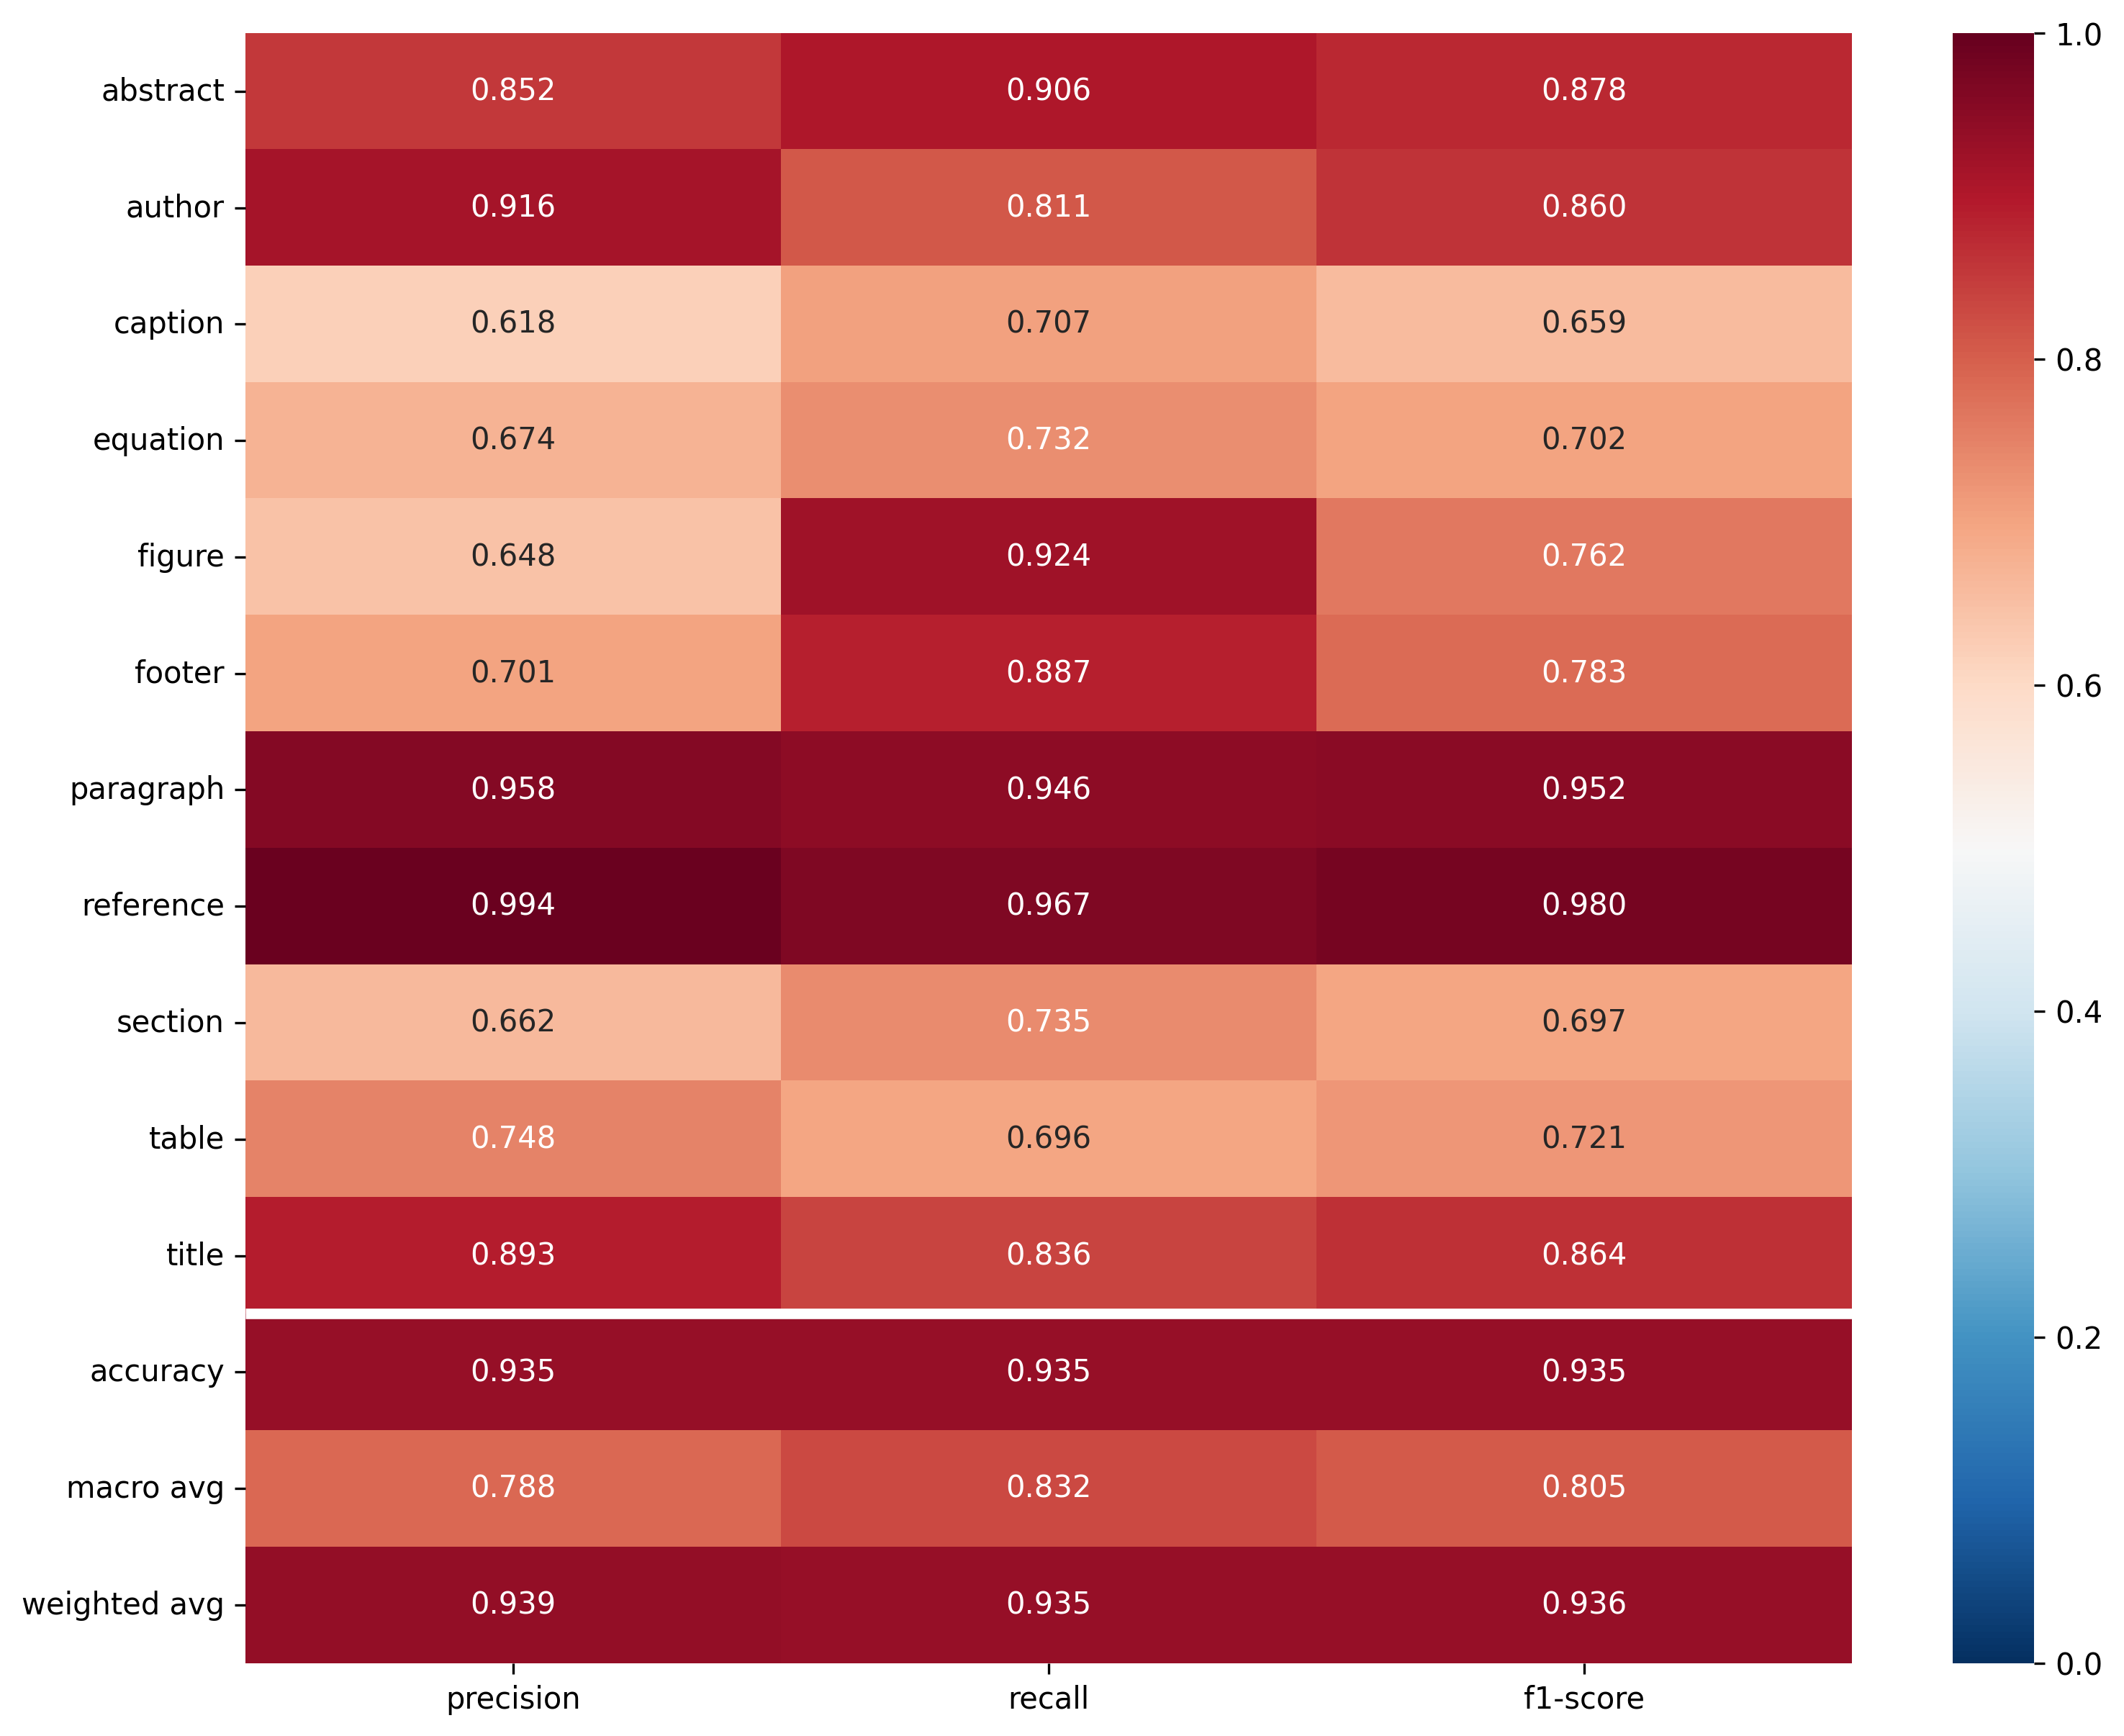

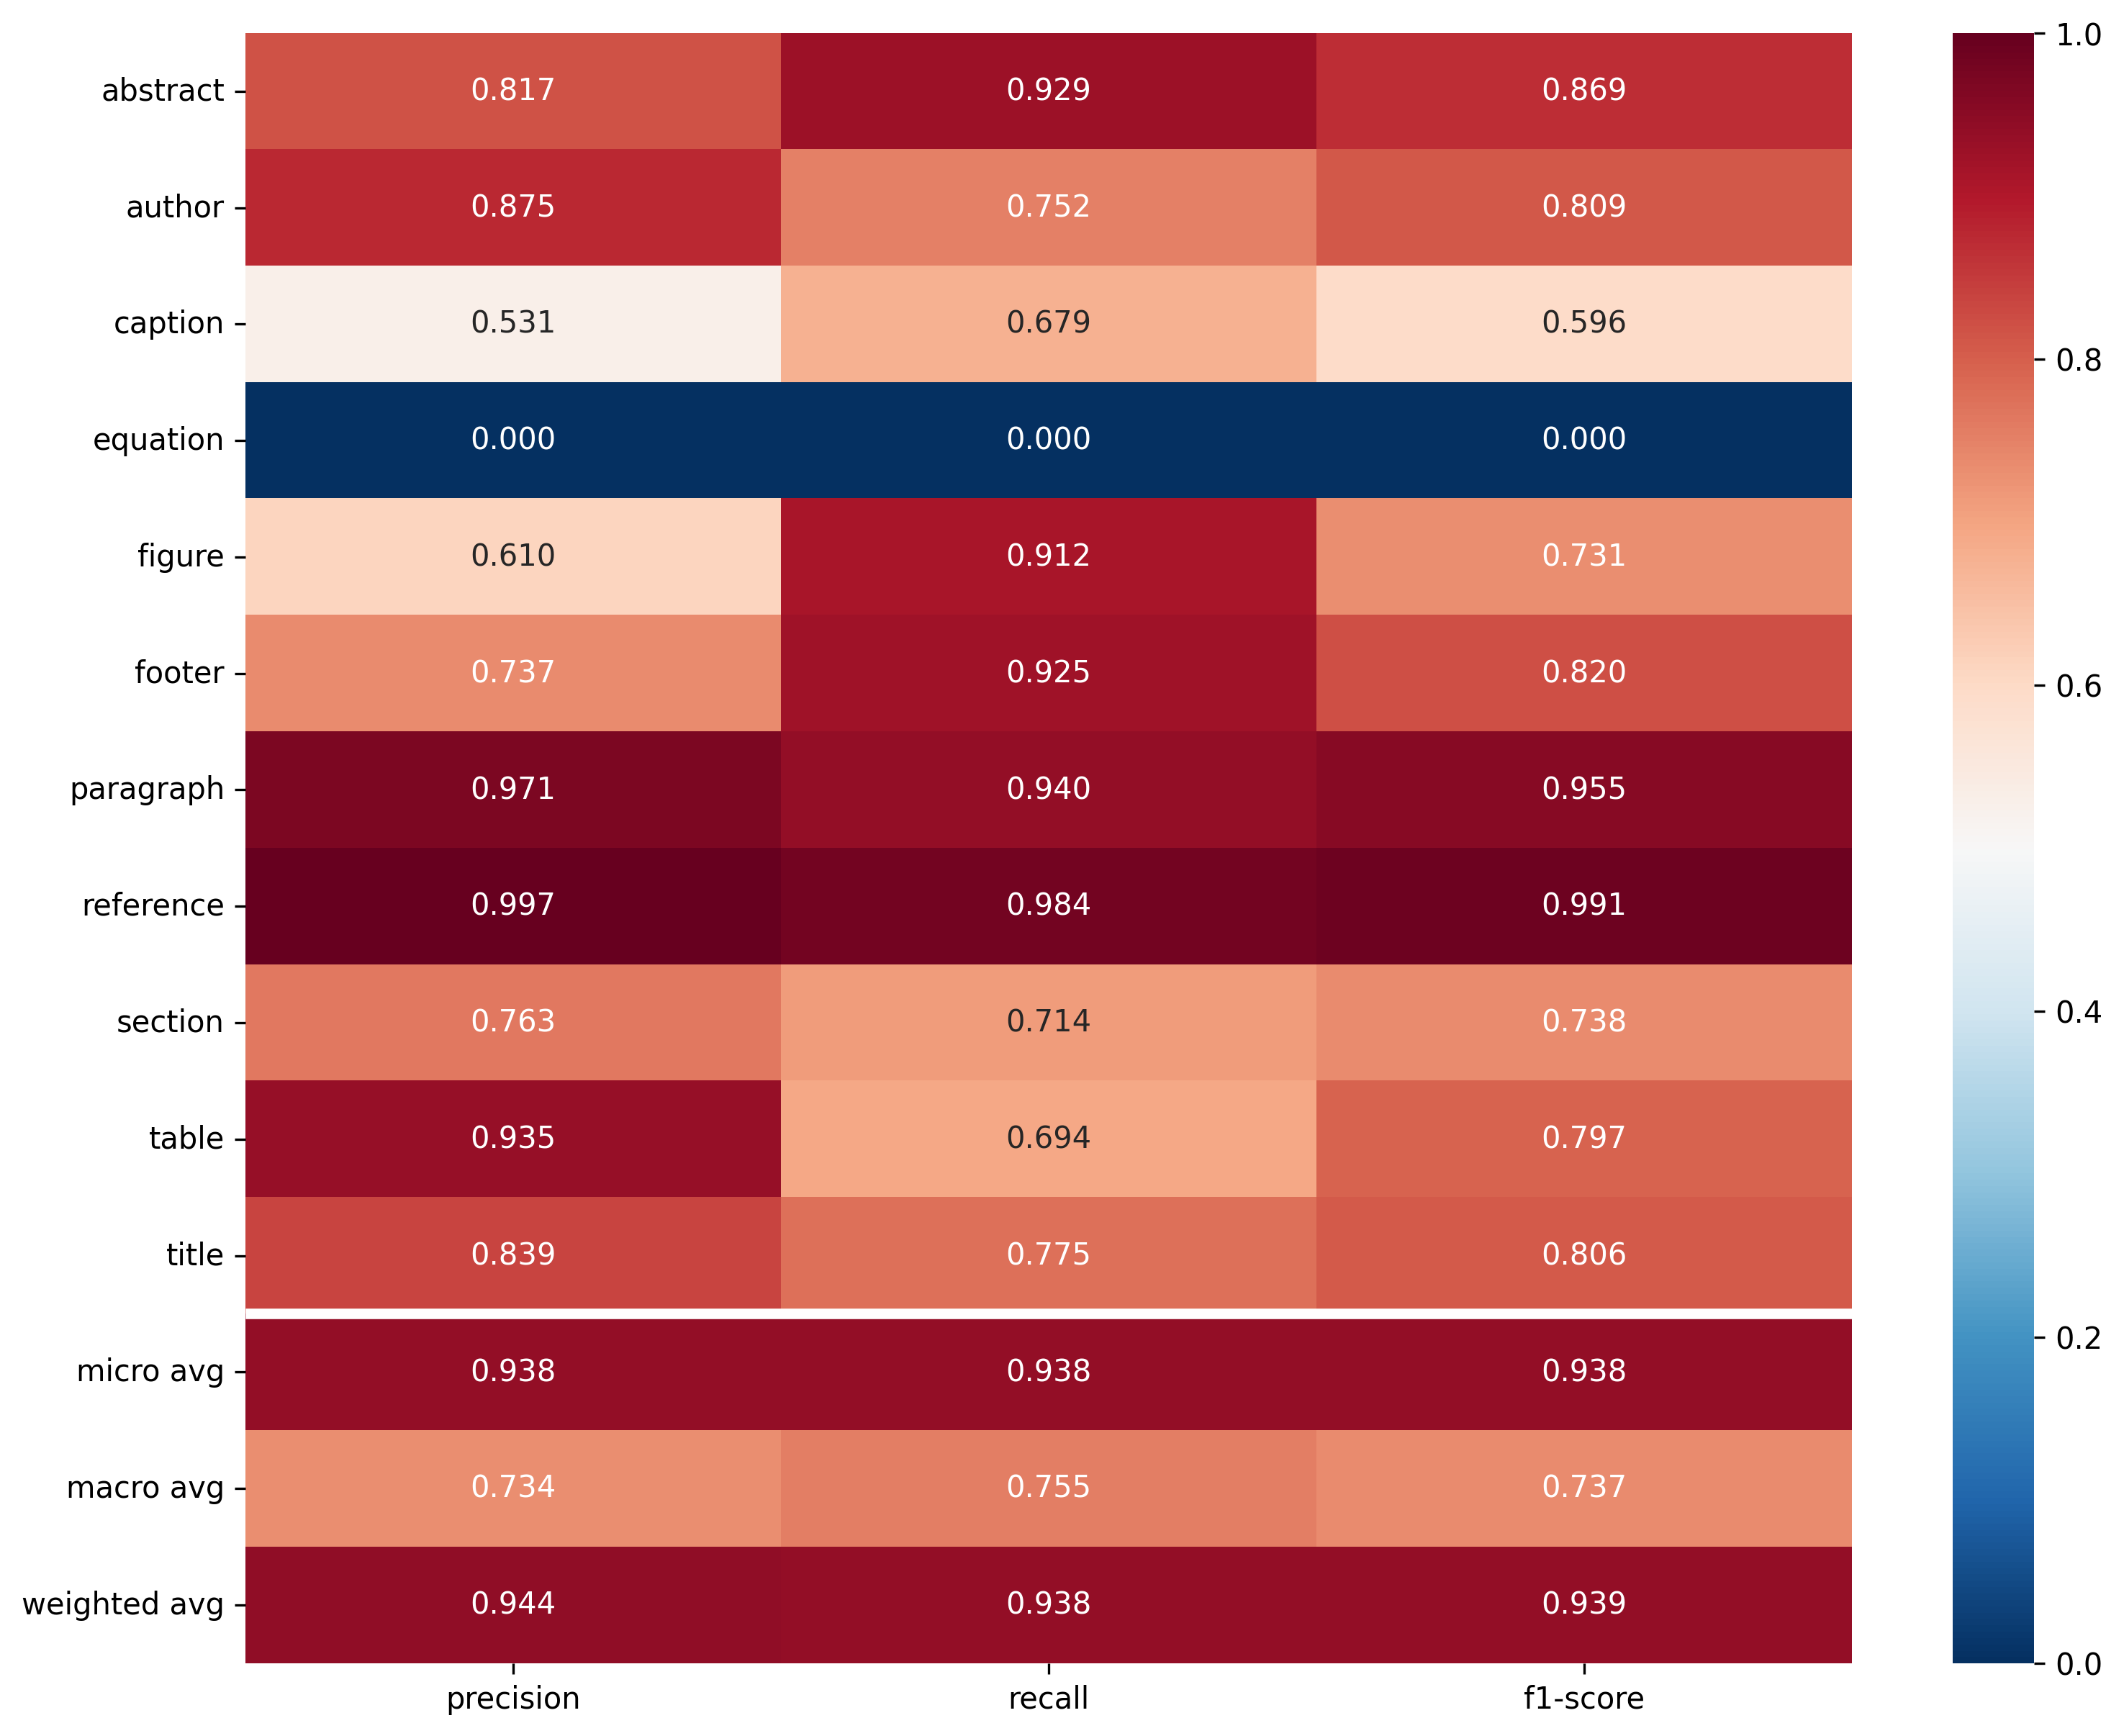

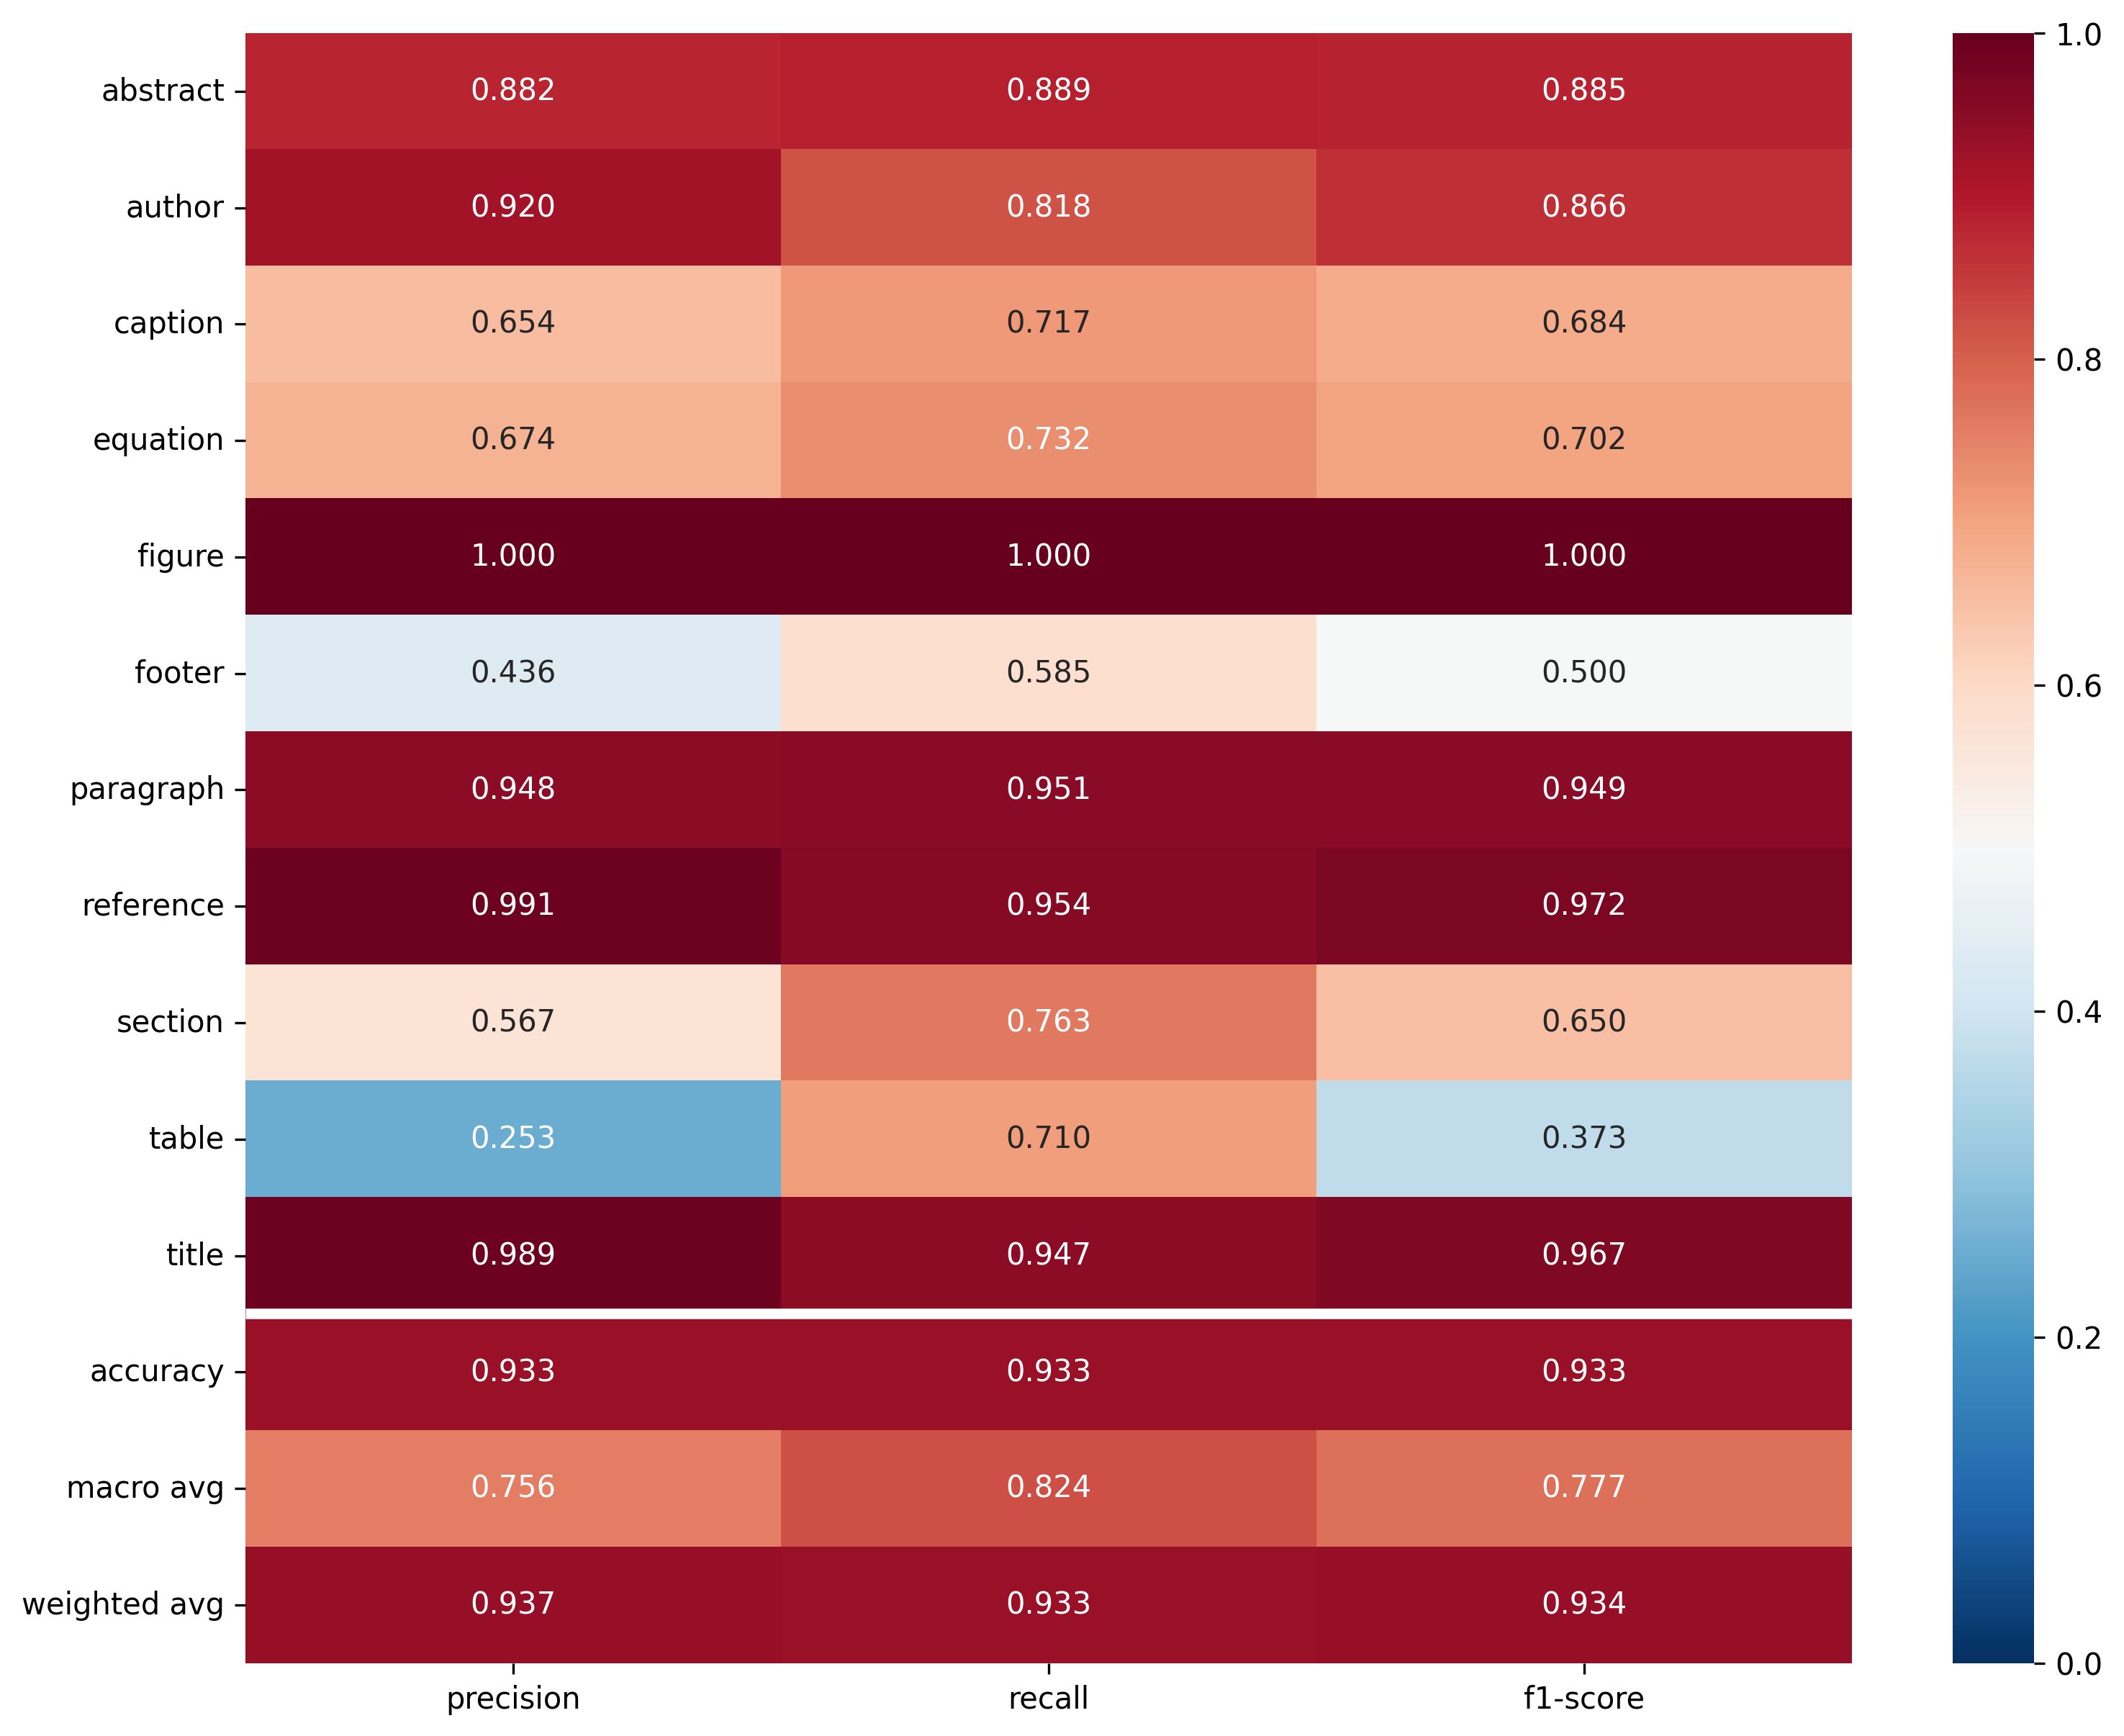

In [ ]:
for key, (y_trues, y_preds) in dataset2pred.items():
    y_trues_label = [id2label[y] for row in y_trues for y in row]
    y_preds_label = [id2label[y] for row in y_preds for y in row]

    report = classification_report(y_trues_label, y_preds_label, labels=labels, output_dict=True)
    df_cr = pd.DataFrame(report)
    fig, ax = plt.subplots(figsize=(12,10), dpi=300) 
    sns.heatmap(df_cr.iloc[:-1, :].T, annot=True, fmt=".3f", cmap= 'RdBu_r', vmin=0, vmax=1, ax=ax )
    ax.hlines([len(labels)], *ax.get_xlim(), colors="white", linewidths = 3.5)
    print(f"Plotting evaluation for '{key}'.")
    fig.show()
    fig.savefig(base_filename + "cls_report_" + key + ".png")

In [ ]:
for key, (y_trues, y_preds) in dataset2pred.items():
    y_trues_label = [id2label[y] for row in y_trues for y in row]
    y_preds_label = [id2label[y] for row in y_preds for y in row]

    for norm in ["true", "pred"]:
        confusion_matrix = metrics.confusion_matrix(y_trues_label, y_preds_label, normalize=norm, labels=labels)
        df_cm = pd.DataFrame(confusion_matrix, index = labels,
                        columns = labels)
        #plt.figure(figsize = (10,10))
        fig, ax = plt.subplots(figsize=(12,10), dpi=300)
        s = sns.heatmap(df_cm, annot=True, fmt=".3f", cmap= 'RdBu_r', ax=ax, vmin=0, vmax=1)
        s.set(xlabel='Predicted labels', ylabel='True labels')
        plt.yticks(rotation=0) 
        plt.xticks(rotation=30) 
        fig.show()
        fig.savefig(base_filename + f"conf_matrix_norm_{norm}_" + key + ".png")

In [ ]:
print('Compressing image files...')
path_csv_files = glob('*.png')
with zipfile.ZipFile(base_filename + '11_1_23.zip', 'w') as zipMe:
    for file in tqdm(path_csv_files):
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)
!find . -name "*.png" -type f -delete

Compressing image files...


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to layout-xlm-geocite-v2
Configuration saved in layout-xlm-geocite-v2/config.json
Model weights saved in layout-xlm-geocite-v2/pytorch_model.bin
tokenizer config file saved in layout-xlm-geocite-v2/tokenizer_config.json
Special tokens file saved in layout-xlm-geocite-v2/special_tokens_map.json
Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.30k/1.38G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|#########9| 3.30k/3.31k [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.30k/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.30k/4.83M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/MrPotato/layout-xlm-geocite-v2
   23ccfa8..5bc7344  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/MrPotato/layout-xlm-geocite-v2
   23ccfa8..5bc7344  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Token Classification', 'type': 'token-classification'}}
To https://huggingface.co/MrPotato/layout-xlm-geocite-v2
   5bc7344..a3c9a50  main -> main

   5bc7344..a3c9a50  main -> main



'https://huggingface.co/MrPotato/layout-xlm-geocite-v2/commit/5bc73442cfa797e7c1f029432a67ed64b8c23dfd'